### 🏆 VertexAI Training
📌 Description

This notebook outlines the steps to run a custom training job on Google Cloud Vertex AI Training.

### ✅ Step 1: Authenticate & Set Up Your Google Cloud Environment


In [ ]:
# 1. Log in to your Google Cloud account
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=YmZwj6CEU9neeCMwZJ8UPOwdYkQlv0&prompt=consent&token_usage=remote&access_type=offline&code_challenge=Ql20h7mukr196xcvnNrlpaOVQBnuyaEnhZgss7iV8dk&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AUJR-x652cmClAHsmjoPqPDHsz7ZVXU_5mZcfzommyQCfX_QpzCnG3gMGo9mVz8Hc6S2mw

You are now logged in as [xperson977@gmail.com].
Your current project i

In [ ]:
# Create a project if you haven't already done so
PROJECT_ID = "hackai-1337-2025-test"
PROJECT_NAME = "My Test Project"

!gcloud projects create "$PROJECT_ID" --name="$PROJECT_NAME"

# Set it as your active project
!gcloud config set project "$PROJECT_ID"

ERROR: (gcloud.projects.create) Project creation failed. The project ID you specified is already in use by another project. Please try an alternative ID.
Updated property [core/project].


In [ ]:
# Link Billing Account

# Output Example:
# ACCOUNT_ID            NAME                OPEN  MASTER_ACCOUNT_ID
# 01A2B3-XXXXXX-YYYYYY  My Billing Account  True
# Your BILLING_ACCOUNT_ID is the value in the ACCOUNT_ID column (01A2B3-XXXXXX-YYYYYY)

!gcloud billing accounts list

In [ ]:
BILLING_ACCOUNT_ID = "BILLING_ACCOUNT_ID_HERE"

!gcloud billing projects link "$PROJECT_ID" --billing-account="$BILLING_ACCOUNT_ID"

billingAccountName: billingAccounts/015D79-A88FA5-6508DE
billingEnabled: true
name: projects/hackai-1337-2025-test/billingInfo
projectId: hackai-1337-2025-test


### ✅ Step 2: Enable required APIs


In [ ]:
!gcloud services enable compute.googleapis.com # For Compute Engine API
!gcloud services enable artifactregistry.googleapis.com # For Artifact Registry API
!gcloud services enable aiplatform.googleapis.com # For Vertex AI API
!gcloud services enable cloudbuild.googleapis.com # For Cloud Build API

In [ ]:
USER_EMAIL = "YOUR_GCP_EMAIL"

!gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="user:$USER_EMAIL" \
    --role="roles/cloudbuild.builds.editor"

Updated IAM policy for project [hackai-1337-2025-test].
bindings:
- members:
  - serviceAccount:service-939735768295@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-939735768295@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:service-939735768295@gcp-sa-artifactregistry.iam.gserviceaccount.com
  role: roles/artifactregistry.serviceAgent
- members:
  - serviceAccount:939735768295@cloudbuild.gserviceaccount.com
  role: roles/cloudbuild.builds.builder
- members:
  - user:xperson977@gmail.com
  role: roles/cloudbuild.builds.editor
- members:
  - serviceAccount:service-939735768295@gcp-sa-cloudbuild.iam.gserviceaccount.com
  role: roles/cloudbuild.serviceAgent
- members:
  - serviceAccount:service-939735768295@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:service-939735768295@containerregist

### ✅ Step 3: Convert Your Training Notebook to Python Script
This step assumes that you already have a notebook containing the code for your model's training step. We will generate a .py file from your notebook.
Upload your notebook and run the following command.

In [ ]:
!jupyter nbconvert notebook_name.ipynb --to python

[NbConvertApp] Converting notebook notebook_name.ipynb to python
[NbConvertApp] Writing 86 bytes to notebook_name.py


In [ ]:
# Create a trainer directory and move the .py code to it
!mkdir trainer
# !mv notebook_name.py trainer/task.py
!mv notebook_name.py trainer/task.py

In [ ]:
# Create your requirements.txt with your needed libraries needed for fintenuning

packages = """
transformers
datasets
"""

!echo "$packages" > requirements.txt

### ✅ Step 4: Create a Dockerfile

In [ ]:
dockerfile_content = """
FROM us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.2-4.py310:latest

WORKDIR /

COPY trainer /trainer
COPY requirements.txt .

RUN pip install --upgrade pip && pip install -r requirements.txt

ENTRYPOINT ["python", "-m", "trainer.task"]
"""

with open("Dockerfile", "w") as f:
    f.write(dockerfile_content)

### ✅ Step 5: Build and Push Container

In [ ]:
REPO_NAME = "hackai-docker-repo"

!gcloud artifacts repositories create "$REPO_NAME" --repository-format=docker \
--location=us-central1 --description="Docker repository"

!gcloud auth configure-docker us-central1-docker.pkg.dev

IMAGE_URI=f"us-central1-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME}/my_image:latest"
IMAGE_URI

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists
`docker` and `docker-credential-gcloud` need to be in the same PATH in order to work correctly together.
gcloud's Docker credential helper can be configured but it will not work until this is corrected.
Adding credentials for: us-central1-docker.pkg.dev
After update, the following will be written to your Docker config file located 
at [/root/.docker/config.json]:
 {
  "credHelpers": {
    "us-central1-docker.pkg.dev": "gcloud"
  }
}

Do you want to continue (Y/n)?  y

Docker configuration file updated.


'us-central1-docker.pkg.dev/hackai-1337-2025-test/hackai-docker-repo/my_image:latest'

In [ ]:
!mkdir -p build_context/trainer
!cp Dockerfile requirements.txt build_context/
!cp -r trainer/task.py build_context/trainer/

In [ ]:
!cd build_context
!gcloud builds submit --tag="$IMAGE_URI" --project="$PROJECT_ID"

Creating temporary archive of 53 file(s) totalling 54.4 MiB before compression.
Uploading tarball of [.] to [gs://hackai-1337-2025-test_cloudbuild/source/1747040928.865039-1412654ea6f043988bbe7176f833116f.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/hackai-1337-2025-test/locations/global/builds/27765f94-59d1-45dd-b70f-fad3f6ff768d].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/27765f94-59d1-45dd-b70f-fad3f6ff768d?project=939735768295 ].
Waiting for build to complete. Polling interval: 1 second(s).
 REMOTE BUILD OUTPUT
starting build "27765f94-59d1-45dd-b70f-fad3f6ff768d"

FETCHSOURCE
Fetching storage object: gs://hackai-1337-2025-test_cloudbuild/source/1747040928.865039-1412654ea6f043988bbe7176f833116f.tgz#1747040940284819
Copying gs://hackai-1337-2025-test_cloudbuild/source/1747040928.865039-1412654ea6f043988bbe7176f833116f.tgz#1747040940284819...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation co

### ✅ Step 6: Run the Training Job

In [ ]:
# Create a bcuket name (mandatory for the job to run)
BUCKET_NAME="gs://hackai-training-bucket"
REGION = "us-central1"
!gcloud storage buckets create $BUCKET_NAME --location=$REGION

Creating gs://hackai-training-bucket/...


In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location="us-central1")

job = aiplatform.CustomContainerTrainingJob(
    display_name='my-training-job',
    container_uri=IMAGE_URI,
    staging_bucket=BUCKET_NAME
)

job.run(
    replica_count=1,
    machine_type='n1-standard-8', # To be customized
    accelerator_type='NVIDIA_TESLA_V100', # # To be customized
    accelerator_count=1
)


#### Waiting for the job to finish

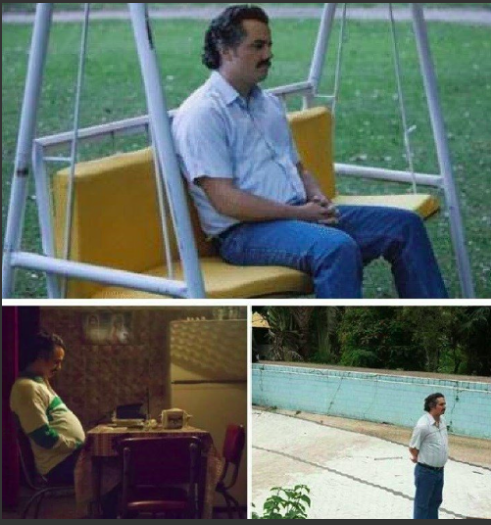